## 1. Preparation

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1.1. Import data

In [ ]:
df = pd.read_csv('Data/Data_5xsum3y.csv')
df

,Date,Temp,EC,pH,Bicarbonate,TKN,Cyano
0,1985/6/1,13.0,512,7.8,204.00,0.68,32018.4
1,1985/6/2,13.0,512,7.8,204.00,0.68,19029.6
2,1985/6/3,13.0,512,7.8,204.00,0.68,6048.0
3,1985/6/4,12.0,525,7.8,204.00,0.76,5292.0
4,1985/6/5,12.0,525,7.8,204.00,0.76,4536.0
...,...,...,...,...,...,...,...
1076,1988/5/27,13.0,435,7.6,142.80,1.46,0.0
1077,1988/5/28,13.0,435,7.6,142.80,1.46,0.0
1078,1988/5/29,13.0,435,7.6,142.80,1.46,0.0
1079,1988/5/30,13.0,435,7.6,142.80,1.46,0.0


In [9]:
data = df.iloc[:, 1:]
data = data.astype('float32')
data

,Temp,EC,pH,Bicarbonate,TKN,Cyano
0,13.0,512.0,7.8,204.000000,0.68,32018.400391
1,13.0,512.0,7.8,204.000000,0.68,19029.599609
2,13.0,512.0,7.8,204.000000,0.68,6048.000000
3,12.0,525.0,7.8,204.000000,0.76,5292.000000
4,12.0,525.0,7.8,204.000000,0.76,4536.000000
...,...,...,...,...,...,...
1076,13.0,435.0,7.6,142.800003,1.46,0.000000
1077,13.0,435.0,7.6,142.800003,1.46,0.000000
1078,13.0,435.0,7.6,142.800003,1.46,0.000000
1079,13.0,435.0,7.6,142.800003,1.46,0.000000


## 2. Construction of data sets

### 2.1. Processing outliers

In [10]:
from scipy.stats import zscore

# Calculate the Z-Score for each column
for col in data.columns:
    data['ZScored'] = zscore(data[col])
    rolling_mean = data[col].rolling(window=5, center=True, min_periods=1).mean()
    data[col] = data.apply(lambda row: rolling_mean[row.name] if abs(row['ZScored']) > 2 else row[col], axis=1)
 
data = data.drop(columns=['ZScored'])
data

,Temp,EC,pH,Bicarbonate,TKN,Cyano
0,13.0,512.0,7.80,204.000000,0.68,32018.400391
1,13.0,512.0,7.80,204.000000,0.68,19029.599609
2,13.0,512.0,7.80,204.000000,0.68,6048.000000
3,12.0,525.0,7.80,204.000000,0.76,5292.000000
4,12.0,525.0,7.80,204.000000,0.76,4536.000000
...,...,...,...,...,...,...
1076,13.0,435.0,7.60,142.800003,1.46,0.000000
1077,13.0,435.0,7.60,142.800003,1.46,0.000000
1078,13.0,435.0,7.64,142.800003,1.46,0.000000
1079,13.0,435.0,7.65,142.800003,1.46,0.000000


### 2.2. Set features and targets

In [11]:
feature_size = 5
target_size = 1

features = data[data.columns[:feature_size]].values.copy()
targets = data['Cyano'].values.copy()

features.shape, targets.shape

((1081, 5), (1081,))

### 2.3. Split data set

In [ ]:
win_size = 30 # Sliding window size
pre_times = 1 # Time step of prediction

dataX = []
dataY = []
for index in range(len(data) - win_size - pre_times): 
    window_X = features[index: index + win_size, :]        
    target_Y = targets[index + win_size:index + win_size + pre_times]
    dataX.append(window_X)
    dataY.append(target_Y)

dataX = np.array(dataX)
dataY = np.array(dataY)

dataX.shape, dataY.shape

((1050, 30, 5), (1050, 1))

In [ ]:
train_size = int(np.round(0.8 * dataX.shape[0]))
x_train = dataX[: train_size, :]
y_train = dataY[: train_size, :]
x_test = dataX[train_size:, :]
y_test = dataY[train_size:, :]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((840, 30, 5), (840, 1), (210, 30, 5), (210, 1))

### 2.4. Normalize the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

x_train = MinMaxScaler().fit_transform(x_train.reshape(-1, feature_size))
y_train = MinMaxScaler().fit_transform(y_train)
x_test = MinMaxScaler().fit_transform(x_test.reshape(-1, feature_size))
y_test = MinMaxScaler().fit_transform(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25200, 5), (840, 1), (6300, 5), (210, 1))

In [ ]:
x_train_tensor = torch.tensor(x_train.reshape(-1,win_size,feature_size), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1,pre_times,target_size), dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test.reshape(-1,win_size,feature_size), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1,pre_times,target_size), dtype=torch.float32).to(device)

x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape


(torch.Size([840, 30, 5]),
 torch.Size([840, 1, 1]),
 torch.Size([210, 30, 5]),
 torch.Size([210, 1, 1]))

## 3. Model training

### 3.1. Constructing the model

#### TCN-LSTM

In [ ]:
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()
 
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()
 
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
 
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
 
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, outputs, pre_len, num_channels, n_layers, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        self.pre_len = pre_len
        self.n_layers = n_layers
        self.hidden_size = num_channels[-2]
        self.hidden = nn.Linear(num_channels[-1], num_channels[-2])
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, n_layers, bias=True,
                            batch_first=True)  # output (batch_size, obs_len, hidden_size)
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]
 
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-2], outputs)
 
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.network(x)
        x = x.permute(0, 2, 1)
        batch_size, obs_len, features_size = x.shape
        xconcat = self.hidden(x)
        H = torch.zeros(batch_size, obs_len - 1, self.hidden_size).to(device)
        ht = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
        ct = ht.clone()
        for t in range(obs_len):
            xt = xconcat[:, t, :].view(batch_size, 1, -1)
            out, (ht, ct) = self.lstm(xt, (ht, ct))
            htt = ht[-1, :, :]
            if t != obs_len - 1:
                H[:, t, :] = htt
        H = self.relu(H)
        x = self.linear(H)
        return x[:, -self.pre_len:, :]

In [ ]:
model = TemporalConvNet(num_inputs=feature_size, outputs=target_size, pre_len=pre_times, 
                        num_channels=[32, 32, 32, 32, 32], n_layers=1, 
                        kernel_size=5, dropout=0.1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

### 3.2. Training model

In [ ]:
import time
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

num_epochs = 500
train_loss_list = []
val_loss_list = []
early_stopping_patience = 10

# Define KFold
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True)
KFold_epochs = []

start_time = time.time()
for fold, (train_indices, val_indices) in enumerate(kf.split(x_train_tensor, y_train_tensor)):
    print(f'Fold {fold+1}/{k_folds}')
    train_loader = DataLoader(TensorDataset(x_train_tensor[train_indices], y_train_tensor[train_indices]), batch_size=512, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_train_tensor[val_indices], y_train_tensor[val_indices]), batch_size=512, shuffle=True)
    best_val_loss = float('inf') 
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        for data in train_loader:
            x_train, y_train = data   
            optimizer.zero_grad() 
            y_train_pred = model(x_train)
            loss_training = loss_fn(y_train_pred.reshape(-1, target_size), y_train.reshape(-1, target_size))
            loss_training.backward() 
            optimizer.step() 
            training_loss += loss_training.item()
        train_loss_list.append(training_loss / len(train_loader))
        if lr_scheduler is not None:
            lr_scheduler.step()

        model.eval()
        valing_loss = 0
        val_losses = [] 
        with torch.no_grad():
            for data in val_loader:
                x_val, y_val = data
                y_val_pred = model(x_val)
                loss_valing = loss_fn(y_val_pred.reshape(-1, target_size), y_val.reshape(-1, target_size))
                valing_loss += loss_valing.item()
                val_losses.append(loss_valing.item())
        val_loss_list.append(valing_loss / len(val_loader))
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {lr_scheduler.get_last_lr()}, Training Loss: {training_loss / len(train_loader):.4f}, Valing Loss: {valing_loss / len(val_loader):.4f}")
        elif (epoch+1) == 1:  
            print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {lr_scheduler.get_last_lr()}, Training Loss: {training_loss / len(train_loader):.4f}, Valing Loss: {valing_loss / len(val_loader):.4f}")
        valing_loss = valing_loss / len(val_loader)
        if valing_loss < best_val_loss:
            best_val_loss = valing_loss
            torch.save(model.state_dict(), 'rTCN-LSTM.pth')
            patience_counter = 0  
        else:
            patience_counter += 1  
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            KFold_epochs.append(epoch+1)
            break
        elif epoch == num_epochs - 1:
            KFold_epochs.append(epoch+1)
end_time = time.time()

print(f"Total epochs: {np.sum(KFold_epochs)}")
time_per_epoch = (end_time-start_time)/(np.sum(KFold_epochs))
print(f"Training time: {end_time-start_time}s")
print(f"Time per epoch: {time_per_epoch}s")
print("="*20, "Training Finished", "="*20)


Fold 1/10


Epoch [1/500], Learning Rate: [0.001], Training Loss: 0.0295, Valing Loss: 0.0548
Epoch [10/500], Learning Rate: [0.0009000000000000001], Training Loss: 0.0273, Valing Loss: 0.0563
Early stopping at epoch 11
Fold 2/10
Epoch [1/500], Learning Rate: [0.0009000000000000001], Training Loss: 0.0296, Valing Loss: 0.0191
Epoch [10/500], Learning Rate: [0.0008100000000000001], Training Loss: 0.0286, Valing Loss: 0.0188
Epoch [20/500], Learning Rate: [0.000729], Training Loss: 0.0226, Valing Loss: 0.0175
Epoch [30/500], Learning Rate: [0.0006561000000000001], Training Loss: 0.0149, Valing Loss: 0.0161
Epoch [40/500], Learning Rate: [0.00059049], Training Loss: 0.0096, Valing Loss: 0.0129
Epoch [50/500], Learning Rate: [0.000531441], Training Loss: 0.0071, Valing Loss: 0.0101
Epoch [60/500], Learning Rate: [0.0004782969], Training Loss: 0.0071, Valing Loss: 0.0089
Epoch [70/500], Learning Rate: [0.00043046721], Training Loss: 0.0055, Valing Loss: 0.0089
Epoch [80/500], Learning Rate: [0.00038742

## 4. Model evaluation

### 4.1. Loss graph

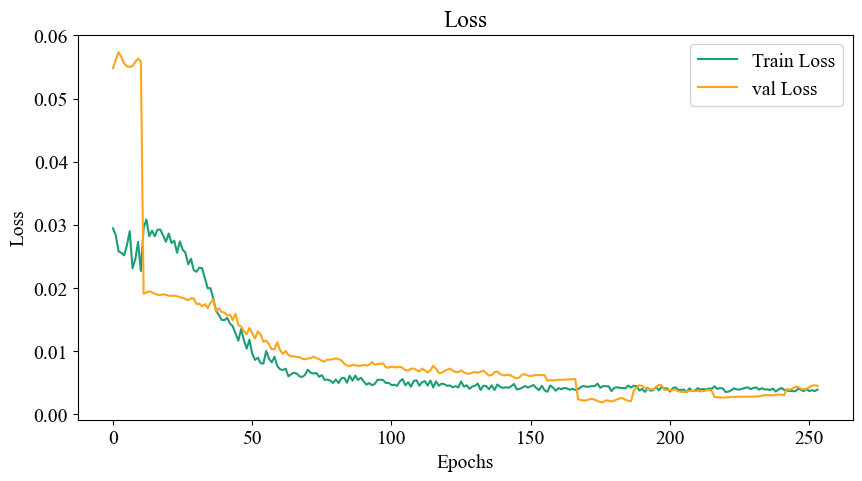

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5), dpi=100)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 14})
plt.plot(train_loss_list, label='Train Loss', color='#1b9e77')
plt.plot(val_loss_list, label='val Loss', color='#FFA319')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

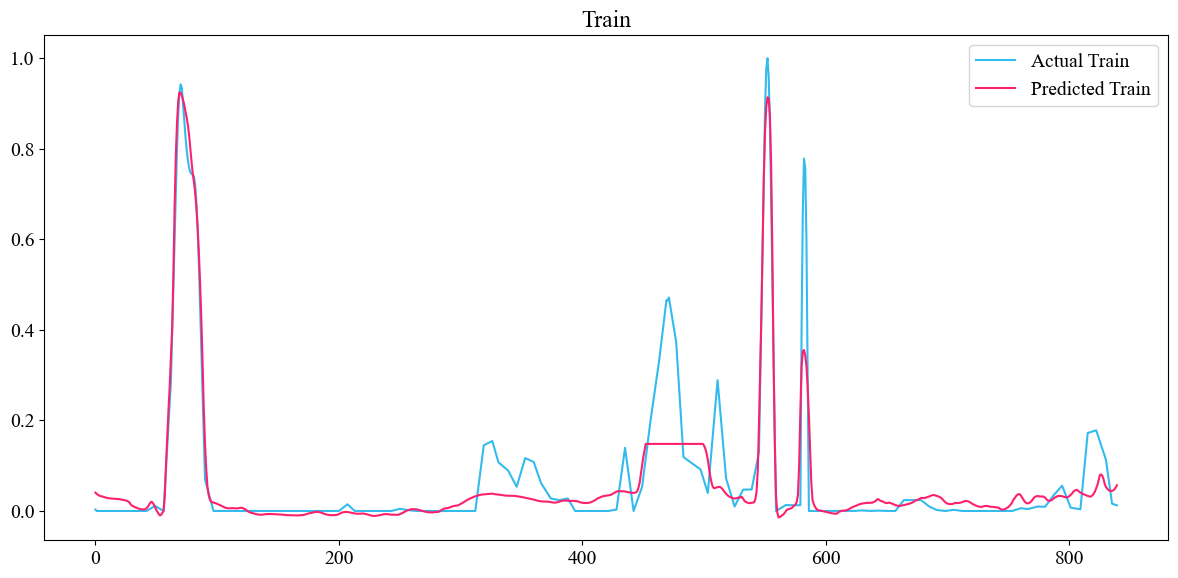

In [ ]:
# Plot the training set results
y_train_pred = model(x_train_tensor)
predicted_train = y_train_pred.cpu().detach().numpy().reshape(-1, target_size)
actual_train = y_train_tensor.cpu().detach().numpy().reshape(-1, target_size)

plt.figure(figsize=(12, 6))
plt.plot(actual_train[:1000], label=f'Actual Train', color='#33BBEE')
plt.plot(predicted_train[:1000], label=f'Predicted Train', color='#fd206e')
plt.legend()
plt.title(f'Train')
plt.tight_layout()
plt.show()

### 4.2. Use the model to predict

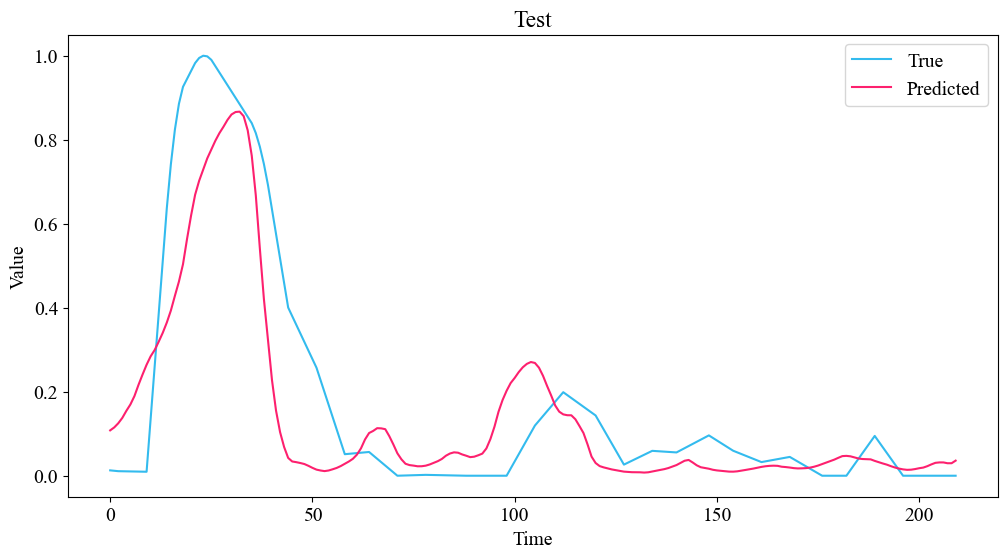

In [ ]:
y_test_pred = model(x_test_tensor)
predicted_test = y_test_pred.cpu().detach().numpy().reshape(-1, target_size)
actual_test = y_test_tensor.cpu().detach().numpy().reshape(-1, target_size)

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(actual_test[:1000], label='True', color='#33BBEE')
plt.plot(predicted_test[:1000], label='Predicted', color='#fd206e')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Test')
plt.show()

### 4.3. Evaluation index

In [720]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

print("MSE: ", mean_squared_error(actual_test, predicted_test))
print("R2 Score: ", r2_score(actual_test, predicted_test))
print("MAE: ", mean_absolute_error(actual_test, predicted_test))
print("MedAE: ", median_absolute_error(actual_test, predicted_test))

MSE:  0.020344753
R2 Score:  0.7548245686706829
MAE:  0.096205756
MedAE:  0.0482988
